In [1]:
# Install required libraries
!pip install yfinance timesfm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.9/51.9 kB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 6.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.8/51.8 kB 2.3 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of googleapis-common-protos to determine which version is compatible with other requirements. This could take a while.
  Using cached jedi-0.19.1-py2.py3-none-any.whl.metadata (22 kB)
INFO: pip is looking at multiple versions of tf-keras to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.7/67.7 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 106.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 MB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.2/440.2 kB 34.2 MB/s e

In [4]:
import os
import time
import timesfm
from collections import defaultdict
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error


In [5]:
# Load TimesFM model
timesfm_backend = "gpu"  # or 'cpu'
from jax._src import config
config.update("jax_platforms", {"cpu": "cpu", "gpu": "cuda", "tpu": ""}[timesfm_backend])

In [7]:
import yfinance as yf
import pandas as pd

# دانلود داده‌های سهام
ticker = 'AAPL'
data = yf.download(ticker, start="2023-01-01", end="2024-01-01")

# بازنمونه‌گیری (resample) به صورت روزانه و پر کردن مقادیر گمشده
data_resampled = data.dropna()

# تبدیل به DataFrame و تنظیم فرمت نهایی
df = data_resampled[['Close']].reset_index()
df.columns = ['date', 'close']
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)

df


[*********************100%***********************]  1 of 1 completed


,close
date,
2023-01-03,125.070000
2023-01-04,126.360001
2023-01-05,125.019997
2023-01-06,129.619995
2023-01-09,130.149994
...,...
2023-12-22,193.600006
2023-12-26,193.050003
2023-12-27,193.149994


In [8]:


def get_batched_data_fn(batch_size: int = 32, context_len: int = 32, horizon_len: int = 1):
    examples = defaultdict(list)
    num_examples = 0
    for start in range(0, len(df) - (context_len + horizon_len), horizon_len):
        num_examples += 1
        context_end = start + context_len
        examples["inputs"].append(df["close"][start:context_end].tolist())
        examples["outputs"].append(df["close"][context_end:context_end + horizon_len].tolist())
        examples["dates"].append(df.index[start:context_end + horizon_len].tolist())  # Add dates to examples

    def data_fn():
        for i in range(1 + (num_examples - 1) // batch_size):
            yield {k: v[(i * batch_size): ((i + 1) * batch_size)] for k, v in examples.items()}

    return data_fn

In [9]:
import timesfm


context_len=64
input_patch_len=32
horizon_len=1
batch_size=1


model = timesfm.TimesFm(
    context_len=context_len,
    horizon_len=horizon_len,
    input_patch_len=input_patch_len,
    output_patch_len=128,
    num_layers=20,
    model_dims=1280,
    backend=timesfm_backend,
)
model.load_from_checkpoint(repo_id="google/timesfm-1.0-200m")

2024-09-04 08:48:47.436387: W external/xla/xla/service/gpu/nvptx_compiler.cc:718] The NVIDIA driver's CUDA version is 12.2 which is older than the ptxas CUDA version (12.6.68). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

Constructing model weights.


Constructed model weights in 3.34 seconds.
Restoring checkpoint from /root/.cache/huggingface/hub/models--google--timesfm-1.0-200m/snapshots/8775f7531211ac864b739fe776b0b255c277e2be/checkpoints.


ERROR:absl:For checkpoint version > 1.0, we require users to provide
          `train_state_unpadded_shape_dtype_struct` during checkpoint
          saving/restoring, to avoid potential silent bugs when loading
          checkpoints to incompatible unpadded shapes of TrainState.


Restored checkpoint in 4.05 seconds.
Jitting decoding.
Jitted decoding in 22.68 seconds.


In [10]:
      input_data = get_batched_data_fn(batch_size=batch_size, context_len=context_len, horizon_len=horizon_len)
      metrics = defaultdict(list)
      results = []

      # Process in smaller sub-batches
      for i, example in enumerate(input_data()):
          raw_forecast, _ = model.forecast(
              inputs=example["inputs"], freq=[0] * len(example["inputs"])
          )

          for j in range(len(example["inputs"])):
              result = {
                  'input_index': j,
                  'train_start_date': str(example["dates"][j][0]),
                  'train_end_date': str(example["dates"][j][-2]),
                  'predict_date': str(example["dates"][j][-1]),
                  'raw_forecast': raw_forecast[j][0],
                  'y_actual': example["outputs"][j][0],
                  'batch_size': batch_size,
                  'context_len': context_len,
                  'input_patch_len': input_patch_len
              }
              results.append(result)

In [11]:
 results_df = pd.DataFrame(results)
 results_df

,input_index,train_start_date,train_end_date,predict_date,raw_forecast,y_actual,batch_size,context_len,input_patch_len
0,0,2023-01-03 00:00:00,2023-04-04 00:00:00,2023-04-05 00:00:00,166.959579,163.759995,1,64,32
1,0,2023-01-04 00:00:00,2023-04-05 00:00:00,2023-04-06 00:00:00,165.057465,164.660004,1,64,32
2,0,2023-01-05 00:00:00,2023-04-06 00:00:00,2023-04-10 00:00:00,165.524918,162.029999,1,64,32
3,0,2023-01-06 00:00:00,2023-04-10 00:00:00,2023-04-11 00:00:00,162.622696,160.800003,1,64,32
4,0,2023-01-09 00:00:00,2023-04-11 00:00:00,2023-04-12 00:00:00,161.525681,160.100006,1,64,32
...,...,...,...,...,...,...,...,...,...
180,0,2023-09-21 00:00:00,2023-12-20 00:00:00,2023-12-21 00:00:00,195.240768,194.679993,1,64,32
181,0,2023-09-22 00:00:00,2023-12-21 00:00:00,2023-12-22 00:00:00,194.696442,193.600006,1,64,32
182,0,2023-09-25 00:00:00,2023-12-22 00:00:00,2023-12-26 00:00:00,194.012909,193.050003,1,64,32
183,0,2023-09-26 00:00:00,2023-12-26 00:00:00,2023-12-27 00:00:00,193.501068,193.149994,1,64,32


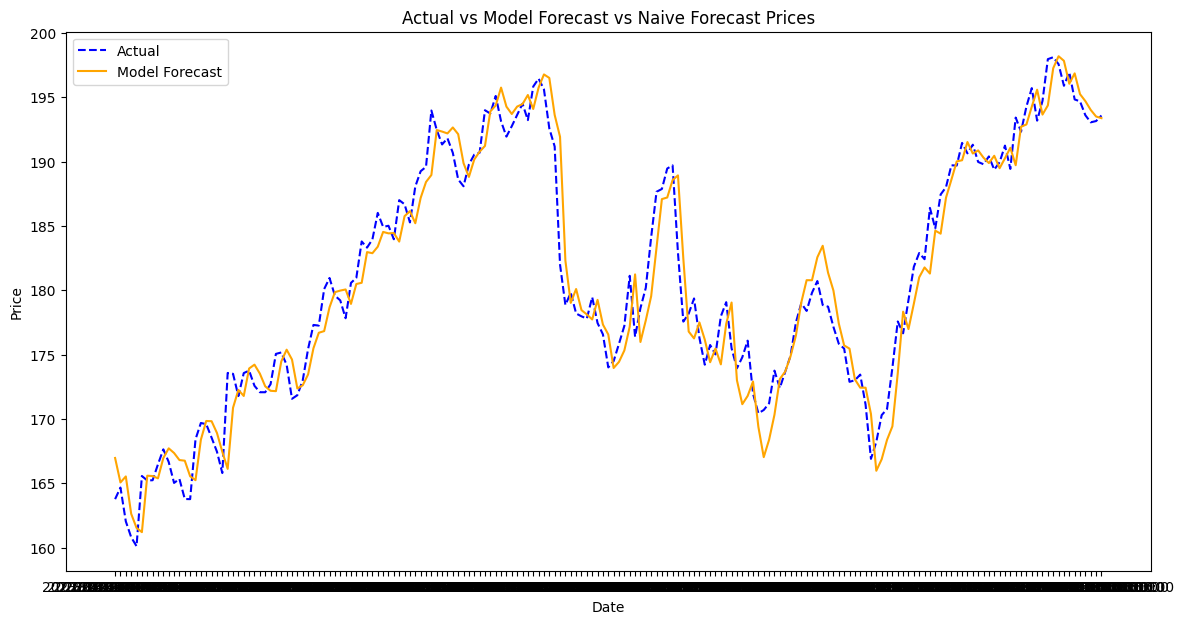

In [12]:
plt.figure(figsize=(14, 7))
plt.plot(results_df['predict_date'], results_df['y_actual'], label='Actual', color='blue', linestyle='--')
plt.plot(results_df['predict_date'], results_df['raw_forecast'], label='Model Forecast', color='orange')

plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Actual vs Model Forecast vs Naive Forecast Prices')
plt.legend()
plt.show()

In [15]:
import pandas as pd
from sklearn.metrics import mean_squared_error, accuracy_score

# Generalized MSE calculation function
def calculate_mse(y_actual, y_forecast):
    return mean_squared_error(y_actual, y_forecast)

# Generalized accuracy function
def calculate_accuracy(y_actual, y_forecast):
    correct_predictions = 0
    total_predictions = 0
    for i in range(1, len(y_actual)):
        actual_today = y_actual.iloc[i]
        predicted_today = y_forecast.iloc[i]
        actual_yesterday = y_actual.iloc[i - 1]
        actual_movement = actual_today - actual_yesterday
        predicted_movement = predicted_today - actual_yesterday
        if (actual_movement > 0 and predicted_movement > 0) or (actual_movement < 0 and predicted_movement < 0):
            correct_predictions += 1
        total_predictions += 1

    return correct_predictions / total_predictions if total_predictions > 0 else 0

# Generalized profit calculation function
def calculate_profit(y_actual, y_forecast, initial_capital=100):
    capital = initial_capital
    position = 0

    for i in range(1, len(y_actual)):
        today_price = y_actual.iloc[i]
        yesterday_price = y_actual.iloc[i - 1]
        predicted_today_price = y_forecast.iloc[i]

        if predicted_today_price > yesterday_price:
            if position == 0:
                position = capital / yesterday_price
                capital = 0
        elif predicted_today_price < yesterday_price:
            if position > 0:
                capital = position * yesterday_price
                position = 0

    if position > 0:
        capital = position * y_actual.iloc[-1]

    return capital - initial_capital

# Generalized actual direction accuracy function
def calculate_actual_direction_accuracy(y_actual, y_forecast):
    def get_direction(current_price, next_price):
        return 1 if next_price > current_price else 0

    real_directions = []
    predicted_directions = []

    for i in range(1, len(y_actual)):
        real_directions.append(get_direction(y_actual.iloc[i - 1], y_actual.iloc[i]))
        predicted_directions.append(get_direction(y_actual.iloc[i - 1], y_forecast.iloc[i]))

    return accuracy_score(real_directions, predicted_directions)

# Generalized direction accuracy function
def calculate_direction_accuracy(y_actual, y_forecast):
    def get_direction(current_price, next_price):
        return 1 if next_price > current_price else 0

    real_directions = []
    predicted_directions = []

    for i in range(1, len(y_forecast)):
        real_directions.append(get_direction(y_actual.iloc[i - 1], y_actual.iloc[i]))
        predicted_directions.append(get_direction(y_forecast.iloc[i - 1], y_forecast.iloc[i]))

    return accuracy_score(real_directions, predicted_directions)

# Generalized direction profit calculation function
def calculate_direction_profit(y_actual, y_forecast, initial_capital=100):
    capital = initial_capital
    position = 0

    for i in range(2, len(y_forecast)):
        yesterday_price = y_actual.iloc[i - 1]
        yesterday_predicted_today_price = y_forecast.iloc[i - 1]
        predicted_today_price = y_forecast.iloc[i]

        if predicted_today_price > yesterday_predicted_today_price:
            if position == 0:
                position = capital / yesterday_price
                capital = 0
        elif predicted_today_price < yesterday_predicted_today_price:
            if position > 0:
                capital = position * yesterday_price
                position = 0

    if position > 0:
        capital = position * y_actual.iloc[-1]

    return capital - initial_capital

# Generalized naive forecast MSE calculation function
def calculate_naive_mse(y_actual):
    naive_forecast = y_actual.shift(1).dropna()  # Naive forecast is just the previous day's actual value
    return mean_squared_error(y_actual.iloc[1:], naive_forecast)

# Generalized function to calculate results for any context length
def calculate_results_for_context_len(context_len, y_actual, y_forecast):
    mse_value = calculate_mse(y_actual, y_forecast)
    accuracy_value = calculate_accuracy(y_actual, y_forecast)
    profit = calculate_profit(y_actual, y_forecast)
    direction_accuracy = calculate_direction_accuracy(y_actual, y_forecast)
    actual_direction_accuracy = calculate_actual_direction_accuracy(y_actual, y_forecast)
    direction_profit = calculate_direction_profit(y_actual, y_forecast)

    # Calculate naive MSE
    naive_mse = calculate_naive_mse(y_actual)

    # Buy and hold profit calculation
    initial_investment = 100
    initial_price = y_actual.iloc[0]
    final_price = y_actual.iloc[-1]

    # Calculate the number of shares bought initially
    shares_bought = initial_investment / initial_price

    # Calculate the final value of the investment
    final_investment_value = shares_bought * final_price

    # Calculate the total profit
    buy_and_hold_profit = final_investment_value - initial_investment

    # Create a dictionary of the results
    result = {
        'context_len': context_len,
        'mse': mse_value,
        'accuracy': accuracy_value,
        'direction_accuracy': direction_accuracy,
        'actual_direction_accuracy': actual_direction_accuracy,
        'direction_profit': direction_profit,
        'profit': profit,
        'buy_and_hold_profit': buy_and_hold_profit,
        'naive_mse': naive_mse  # Add naive MSE here
    }

    return pd.DataFrame([result])

# Example usage:
context_len = 64  # Example context length
final_result_df = calculate_results_for_context_len(context_len, results_df['y_actual'], results_df['raw_forecast'])
print(final_result_df)


   context_len       mse  accuracy  direction_accuracy  \
0           64  5.479234  0.456522            0.505435   

   actual_direction_accuracy  direction_profit    profit  buy_and_hold_profit  \
0                   0.456522         11.407498  6.971617             18.20958   

   naive_mse  
0   4.522645  
